In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from static_fun import Boltzman_distribution
from scipy.special import kv

# 单跑跑不通！！！！，缺一个很大的数据集，画的曲面图在老下面


In [2]:
import h5py

with h5py.File('txt_100.mat', 'r') as f:
    # 打印文件中的数据集
    eigfun_mat = {}
    for key in f.keys():
        if isinstance(f[key], h5py.Dataset):
            eigfun_mat[key] = f[key][()]
    # fk_martix=np.zeros_like(eigfun_mat['fk'])
    # for i in range(eigfun_mat['fk'].shape[0]):
    #     for j in range(eigfun_mat['fk'].shape[1]):
    #         for k in range(eigfun_mat['fk'].shape[2]):
    #             fk_martix[i,j,k]=f.get(f['fk'][()][i,j,k])[()]
    #     print(i)
    # np.savez('my_arrays.npz', fk=fk_martix)


import scipy.io as sio

para_mat = sio.loadmat('vpa_100.mat')


In [3]:
fk_test=np.load('my_arrays.npz', allow_pickle=True)['fk'].copy()

In [36]:
xmin=para_mat['xmin']
xmax=para_mat['xmax']
dx=para_mat['dx']
x=np.arange(xmin,xmax+dx/2,dx)        ## 表示计算

omega=para_mat['w']
K=para_mat['K']
gamma=1/para_mat['B']
lamb_range=eigfun_mat['k'].ravel()
Tc_range=eigfun_mat['Tc'].ravel()  
gamma                                   ## T和Lamb是变量。其他的就没有变凉了,然后D也是一个变量，可以不管

array([[0.4]])

In [5]:
def get_factor(L,pi_equ,x):          ##将单个量对应的内积输入,然后输出内积
    lamb2=L[0].ravel()
    lamb3=L[2].ravel()
    L2=L[1].ravel()
    L3=L[3].ravel()
    L_R_2=np.trapz(L2**2*pi_equ,x)           
    L_R_3=np.trapz(L3**2*pi_equ,x)
    a2=L2[np.ceil(len(x)/2).astype(int)]/L_R_2
    a3=L3[np.ceil(len(x)/2).astype(int)]/L_R_3
    factor=[pi_equ,a2*L2*pi_equ,a3*L3*pi_equ]
    factor_x_inter=[np.trapz(factor[i]*x,x) for i in range(len(factor))]
    factor_x2_inter=[np.trapz(factor[i]*x**2,x) for i in range(len(factor))]
    factor_x2_inter[1]=0
    factor_x_inter[0]=0;factor_x_inter[2]=0
    return {"x":factor_x_inter,"x_squre":factor_x2_inter,"eigvalue":[np.array([0]),lamb2,lamb3]}
def x_t_by_eigvalue(para_json,t):
    x_bar=np.sum([para_json['x'][i]*np.exp(para_json['eigvalue'][i]*t) for i in range(len(para_json['x']))],axis=0)
    x2_bar=np.sum([para_json['x_squre'][i]*np.exp(para_json['eigvalue'][i]*t) for i in range(len(para_json['x_squre']))],axis=0)
    return {'x_bar':x_bar,'x2_bar':x2_bar}

In [72]:
def load_from_ij(i,j):
    cc=fk_test[:,i,j]
    T=Tc_range[i]
    lamb=lamb_range[j]
    if len(cc[1].dtype)==2:
        return {'eigvalue_fac':None,'x_t_bar':None,'para':[T,lamb]}
    t=np.arange(0,2,0.01)
    beta=1/K/T
    if lamb!=0:
        x_inner = beta/8/lamb
        v = 1/4
        N_x = 1/(1/2**(1/2)*(1/lamb)**0.5*np.exp(x_inner)*kv(v, x_inner))
    elif lamb==0:
        N_x=1/np.sqrt(2*np.pi/beta)
    def U(x):
        return 1/2*x**2+1/4*lamb*x**4
    pi_equ=Boltzman_distribution(N_x,U,x,T=T).ravel()     ##玻尔兹曼因子
    para_json=get_factor(cc,pi_equ,x)
    return {'eigvalue_fac':para_json,'x_t_bar':x_t_by_eigvalue(para_json,t),'para':[T,lamb]}

In [73]:
tt=np.zeros([len(Tc_range),len(lamb_range)])
data = [[load_from_ij(i,j) for i in range(len(Tc_range))] for j in range(len(lamb_range))]  ## 每一次要重新运行，说明有函数参数没有被改变


9 4
[1.45, 0.2]
1.45 0.2


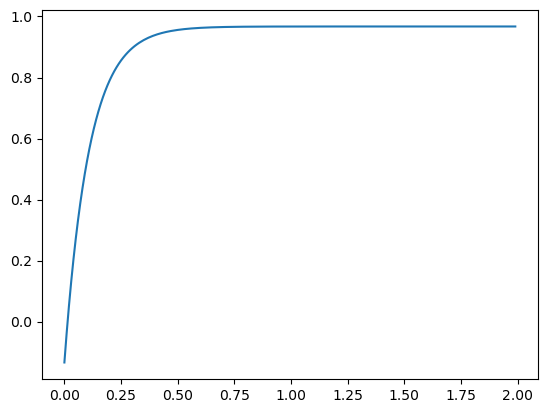

In [239]:
# i=12
# j=2
# i=12
# j=2
t=np.arange(0,2,0.01)
i=9
j=4
print(i,j)
print(data[j][i]['para'])
print(Tc_range[i],lamb_range[j])
T=Tc_range[i]
lamb=lamb_range[j]
plt.plot(t,data[j][i]['x_t_bar']['x2_bar'])
# plt.plot(x,fk_test[1,i,j].ravel())

# data[j][i]['eigvalue_fac']
# data[j][i]['x_t_bar']['x2_bar']


In [240]:
import numpy as np
# import static_fun
# import importlib
# importlib.reload(static_fun)
from static_fun import sde_rk2_gen
from static_fun import gen_ensemble
from static_fun import averge_ensemble
import matplotlib.pyplot as plt
## 设定全局参数值，保证是过阻尼
m=1 
beta=gamma/2
D=K*T*gamma/m  ## 扩散系数张量用于生成随机力
omega_0=1/2*omega+(1/4*omega**4+3*lamb*T/m)**0.5
# omega_1=(-omega_0**2+beta**2)**0.5
def f(x,t):
    # global gamma
    gamma=0.4
    # global omega
    omega=1
    global lamb
    return np.array([(-omega**2*x[0]-lamb*x[0]**3)/gamma])

def noise(delta_t):
    global D
    # global gamma
    gamma=0.4
    return np.array([(2*D*delta_t)**0.5/gamma*np.random.normal()])
def X_square_gen(i):         ## 或者一个gen返回全部的系综值，后面再拿出来处理
    x0=np.array([0])
    # global t
    t=np.arange(0,2,0.01)
    X=sde_rk2_gen(x0,t,f,noise)
    return X

ensemble=gen_ensemble(X_square_gen,10000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


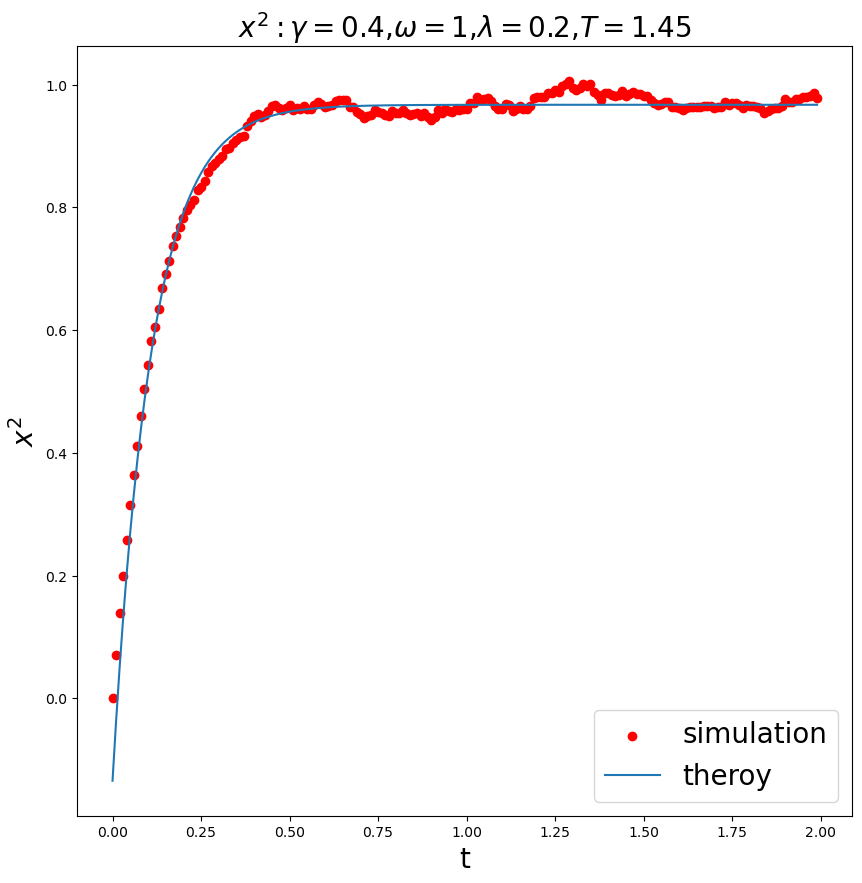

In [241]:
X_averge=averge_ensemble(ensemble)
t=np.arange(0,2,0.01)
X_averge['x_square']
plt.figure(figsize=(10,10))
plt.scatter(t,X_averge['x_square'],c='r')
plt.plot(t,data[j][i]['x_t_bar']['x2_bar'])
plt.legend(['simulation','theroy'],fontsize=20)
plt.xlabel('t',fontsize=20)
plt.ylabel('$x^2$',fontsize=20)
plt.title(f'$x^2:\gamma={gamma[0][0]}$,$\omega={omega[0][0]}$,$\lambda={lamb}$,$T={T}$',fontsize=20)
plt.savefig(f"picture/gamma_{gamma[0][0]}_omega_{omega[0][0]}_lambda_{lamb}_T={T}_x2.eps")

In [131]:
## 
ff=data[1][1]
def get_points(ff):
    T_p_point=ff['para'][0]
    lamb_point=ff['para'][1]
    eig2_point=ff['eigvalue_fac']['eigvalue'][1][0]
    eig3_point=ff['eigvalue_fac']['eigvalue'][2][0]
    return [np.array([T_p_point,lamb_point,eig2_point]),np.array([T_p_point,lamb_point,eig3_point])]


In [213]:
j=0
points_lamb2=[]
points_lamb3=[]
for i in range(len(Tc_range)):
    for j in range(len(lamb_range)):
        if data[j][i]['eigvalue_fac']!=None:
            points_lamb2+=[get_points(data[j][i])[0]]
            points_lamb3+=[get_points(data[j][i])[1]]
points_lamb2=np.array(points_lamb2)
points_lamb3=np.array(points_lamb3)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


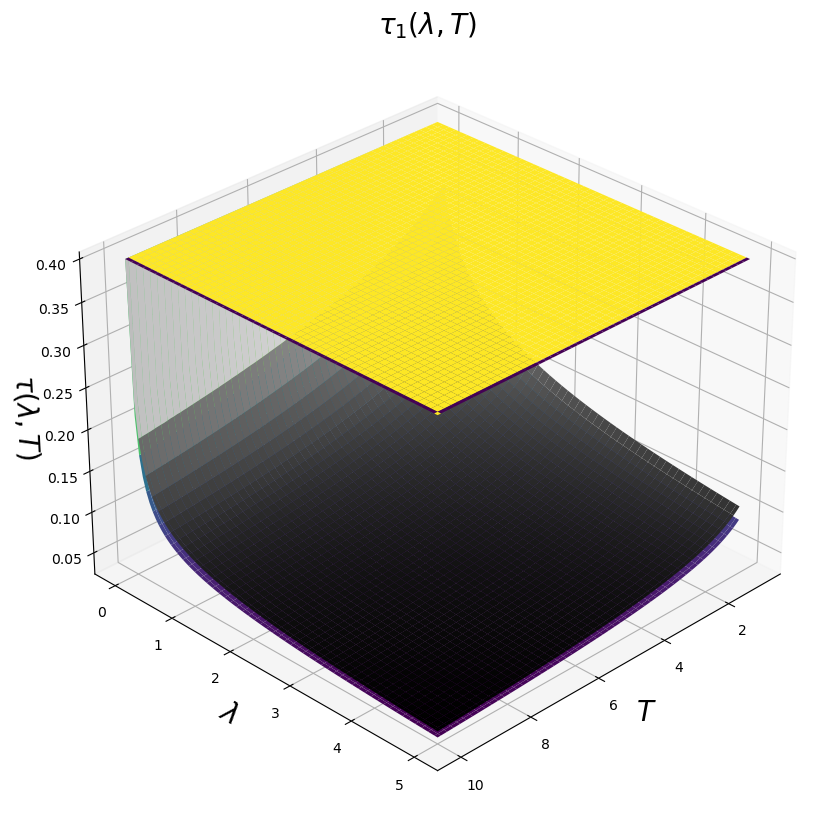

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

x = points_lamb2[:,0]
y = points_lamb2[:,1]
z = 1/-points_lamb2[:,2]

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')
Z2=np.ones_like(X)/(omega**2/gamma)

Omega_points=(1/2*omega+(1/4*omega**4+3*X*Y/m)**0.5)**0.5
Z3=1/(Omega_points**2/gamma)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
surf1=ax.plot_surface(X, Y, Z, cmap='gray')
surf2=ax.plot_surface(X, Y, Z2, cmap='viridis')
surf3=ax.plot_surface(X, Y, Z3, cmap='viridis')
ax.set_xlabel('$T$',fontsize=20)
ax.set_ylabel('$\lambda$',fontsize=20)
ax.set_zlabel(r"$\tau(\lambda,T)$",fontsize=20)
ax.view_init(elev=30, azim=45)
ax.set_title(r'$\tau_1(\lambda,T)$',fontsize=20)
plt.savefig(f"picture/t1_gamma_{gamma[0][0]}_omega_{omega[0][0]}.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


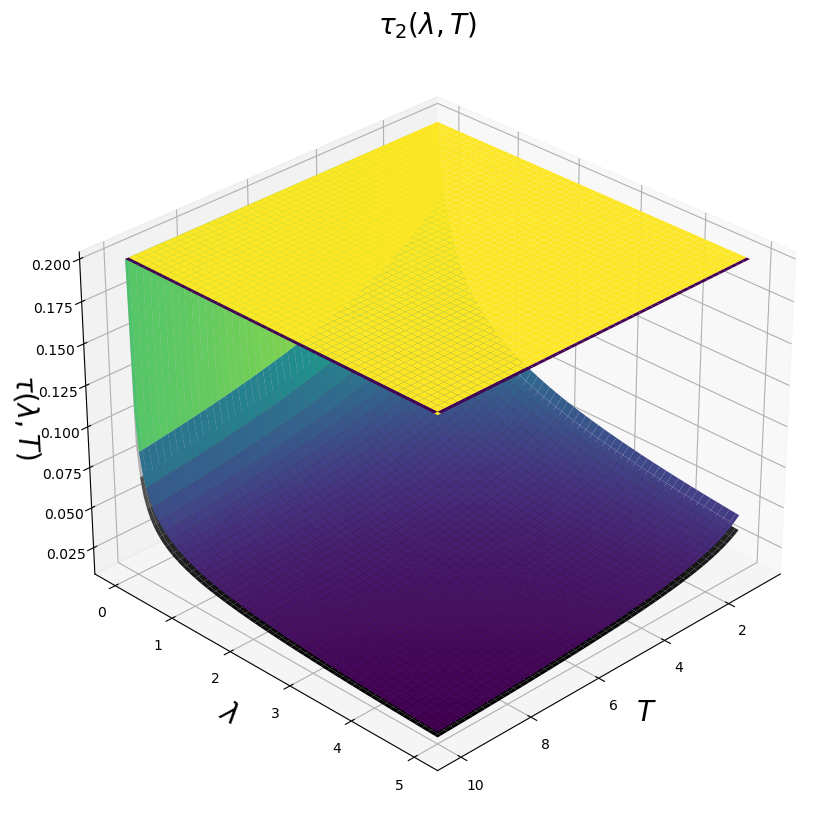

In [245]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

x = points_lamb3[:,0]
y = points_lamb3[:,1]
z = 1/-points_lamb3[:,2]

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')
Z2=np.ones_like(X)/(2*omega**2/gamma)

Omega_points=(1/2*omega+(1/4*omega**4+3*X*Y/m)**0.5)**0.5
Z3=1/(2*Omega_points**2/gamma)
# Z3=gamma/(omega**2+np.sqrt(omega**4+12*X*Y/m))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
surf1=ax.plot_surface(X, Y, Z, cmap='gray')
surf2=ax.plot_surface(X, Y, Z2, cmap='viridis')
surf3=ax.plot_surface(X, Y, Z3, cmap='viridis')
ax.set_xlabel('$T$',fontsize=20)
ax.set_ylabel('$\lambda$',fontsize=20)
ax.set_zlabel(r"$\tau(\lambda,T)$",fontsize=20)
ax.view_init(elev=30, azim=45)
ax.set_title(r'$\tau_2(\lambda,T)$',fontsize=20)
plt.savefig(f"picture/t2_gamma_{gamma[0][0]}_omega_{omega[0][0]}.eps")
plt.show()
